In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

Libraries Imported


In [2]:
# Define paths to the training, validation, and test datasets
train_folder = 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\data\\train'
test_folder = 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\data\\test'
validate_folder = 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\data\\val'

In [3]:
# Define paths to the specific classes within the dataset
adenocarcinoma_folder = 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset\\adenocarcinoma'
benign = 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset\\benign'
squamous_cell_carcinoma_folder = 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset\\squamous_cell_carcinoma'

In [4]:
# Set the image size for resizing
IMAGE_SIZE = (224, 224)

In [5]:
# Define the batch size for training
BATCH_SIZE = 32

cette section permet de split automatiquemet le dataset en trin, test et validation

In [ ]:
import os
import shutil
import torch
from torch.utils.data import random_split
from torchvision import datasets

def copy_split_files(dataset, indices, output_dir, original_root):
    """Copy files from original dataset to new split directory"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Create class directories
    for class_name in dataset.classes:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)
    
    # Copy files
    for idx in indices:
        file_path, class_idx = dataset.samples[idx]
        class_name = dataset.classes[class_idx]
        
        # Get original filename
        filename = os.path.basename(file_path)
        
        # Copy to new location
        src = file_path
        dst = os.path.join(output_dir, class_name, filename)
        shutil.copy2(src, dst)

# Your existing code
full_dataset = datasets.ImageFolder(root='C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset')
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Copy files to new directories
copy_split_files(full_dataset, train_dataset.indices, 'data/train', 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset')
copy_split_files(full_dataset, val_dataset.indices, 'data/val', 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset')
copy_split_files(full_dataset, test_dataset.indices, 'data/test', 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset')

print("Files copied to data/train, data/val, data/test directories")

In [7]:
import tensorflow as tf
import os

# Define train and validation folders
DATA_DIR = 'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer'
train_dir = os.path.join(DATA_DIR, 'data', 'train')  # data/train/
val_dir = os.path.join(DATA_DIR, 'data', 'val')      # data/val/
test_dir = os.path.join(DATA_DIR, 'data', 'test')    # data/test/


# Initialize the image data generators for training and testing
print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)





Reading training images from: C:\Users\HP\Desktop\IABD\deeplearning\DeepLearning_LungCancer\data\train
Reading validation images from: C:\Users\HP\Desktop\IABD\deeplearning\DeepLearning_LungCancer\data\val


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image size for EfficientNet
IMG_SIZE = (224, 224)  # Must be 224x224 for EfficientNet

# Training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test data generators
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True  
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Critical for correct evaluation    
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,  # Use BATCH_SIZE variable
    class_mode='categorical',
    shuffle=False
)



# Verify
print("Class indices:", train_generator.class_indices)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Class indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}
Training samples: 10500
Validation samples: 2250


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [10]:
# Define the number of output classes
OUTPUT_SIZE = 3  

l'utilisation de EfficientNetBO est conseiller car tres efficient pour le cas des maladies mais prend beaucoup de temps, je laisse ca ici pour votre utilisation si votre machine contient toutes les capacité requise pour son execution, nous allons utiliser MobileNetV2 pour une execution plus rapide pour pas que j'ai a patienter pendant je ne sais combien de temps devant mon ordinateur

In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Load EfficientNet with pre-trained weights
pretrained_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3),
    pooling=None  
)

# Freeze layers but keep BatchNorm trainable (critical for transfer learning)
for layer in pretrained_model.layers:
    layer.trainable = False
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True  

# Custom head with regularization
model = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # Helps stabilize training
    Dense(256, activation='relu'),
    Dropout(0.3),  # Reduced from 0.5 to prevent underfitting
    BatchNormalization(),
    Dense(3, activation='softmax')
])

# Compile with learning rate warmup
initial_learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summaries
print("Pretrained model architecture:")
pretrained_model.summary()

print("\nFinal model architecture:")
model.summary()

Pretrained model architecture:


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 42,016 (164.12 KB)

 Non-trainable params: 4,007,555 (15.29 MB)


Final model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,422 (16.73 MB)

 Trainable params: 373,795 (1.43 MB)

 Non-trainable params: 4,010,627 (15.30 MB)

In [13]:
# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Calculate steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
val_steps = val_generator.samples // BATCH_SIZE

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")




Training samples: 10500
Validation samples: 2250
Training steps per epoch: 328
Validation steps per epoch: 70


ici nous utilisons MobileNetV2 pour un entrainement plus rapide mais notez bien que ceci n'est pas la meilleur solution en terme d'accuracy, donc si vous le pouvez vou utiliser EfficientBO lent mais adapter pour ce type de dataset et peut conduire a des probleme de overfitting 

In [15]:
#Use a lighter model for faster training
from tensorflow.keras.applications import MobileNetV2

# Replace EfficientNet with MobileNetV2 (much faster)
pretrained_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3),
    alpha=1.0  # Use full model, but still faster than EfficientNet
)

# Freeze layers
for layer in pretrained_model.layers:
    layer.trainable = False

In [16]:
# Simpler model architecture
model = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),  # Reduced from 256
    Dropout(0.3),
    Dense(3, activation='softmax')
])

#Optimized compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Higher learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  Optimized callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=3, 
        restore_best_weights=True,
        monitor='val_accuracy'  # Focus on accuracy
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5, 
        patience=2, 
        min_lr=1e-6
    )
]

#  Faster training
history = model.fit(
    train_generator,
    steps_per_epoch=62,
    epochs=10,  
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)
print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7875 - loss: 0.5051 - val_accuracy: 0.9308 - val_loss: 0.1972 - learning_rate: 0.0010
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9261 - loss: 0.1887 - val_accuracy: 0.9371 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9427 - loss: 0.1550 - val_accuracy: 0.9304 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9566 - loss: 0.1229 - val_accuracy: 0.9531 - val_loss: 0.1223 - learning_rate: 0.0010
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9326 - loss: 0.1602 - val_accuracy: 0.9290 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 60s 968ms/step - accuracy: 0.9293 - loss: 0.1840 - val_accuracy: 0.9429 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9502 - loss: 0.1350 - val_ac

In [17]:
from sklearn.metrics import classification_report

# Predict on the entire validation set
val_steps = val_generator.samples // val_generator.batch_size + int(val_generator.samples % val_generator.batch_size != 0)
Y_pred_probs = model.predict(val_generator, steps=val_steps)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_val = val_generator.classes

class_labels = list(train_generator.class_indices.keys())

print(classification_report(Y_val, Y_pred, target_names=class_labels))

71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 731ms/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.96      0.90      0.93       762
                 benign       1.00      1.00      1.00       726
squamous_cell_carcinoma       0.91      0.96      0.94       762

               accuracy                           0.95      2250
              macro avg       0.96      0.95      0.95      2250
           weighted avg       0.95      0.95      0.95      2250



In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluate on test set
test_steps = test_generator.samples // test_generator.batch_size
Y_pred = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
print("\nTest Set Evaluation:")
print(classification_report(
    test_generator.classes[:len(y_pred)],  # Align with predictions
    y_pred,
    target_names=list(train_generator.class_indices.keys())
))

70/70 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step

Test Set Evaluation:
                         precision    recall  f1-score   support

         adenocarcinoma       0.97      0.90      0.93       734
                 benign       0.99      1.00      1.00       728
squamous_cell_carcinoma       0.92      0.97      0.94       778

               accuracy                           0.96      2240
              macro avg       0.96      0.96      0.96      2240
           weighted avg       0.96      0.96      0.96      2240



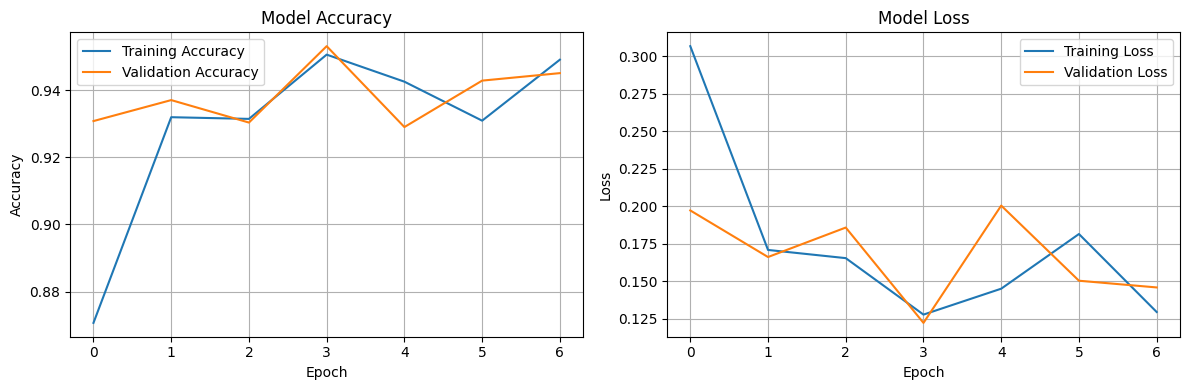

In [42]:
# PLOT TRAINING CURVES
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
plot_training_history(history)

In [ ]:
# Save the trained model
model.save(r'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset\\trained_lung_cancer_model.h5')

In [22]:
# Function to load and preprocess an image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np

In [23]:
# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

In [24]:
# Load, preprocess, and predict the class of an image
# Update img_path to point to an actual image file that exists on your system
img_path = r'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset\\benign\\0000.jpg'  # <-- Update this path

img = load_and_preprocess_image(img_path, IMAGE_SIZE)

In [25]:
# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [26]:
# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

In [27]:
# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

The image belongs to class: benign


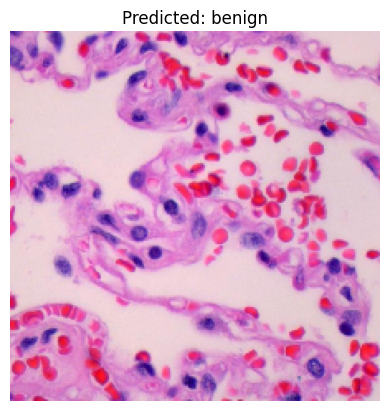

In [28]:
# Display the image with the predicted class
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array


In [30]:
# Load an image from your drive
img_path = r'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset\\squamous_cell_carcinoma\\4990.jpg'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

In [31]:
# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [32]:
# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

In [33]:
# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

The image belongs to class: squamous_cell_carcinoma


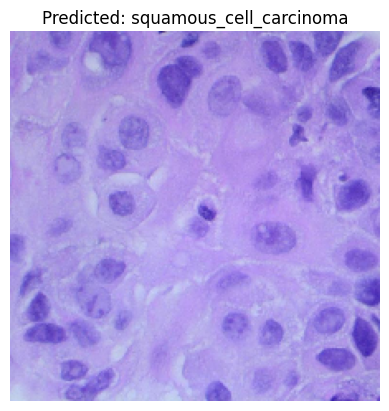

In [34]:
# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

In [35]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array


In [36]:
# Load an image from your drive
img_path = r'C:\\Users\\HP\\Desktop\\IABD\\deeplearning\\DeepLearning_LungCancer\\dataset\\adenocarcinoma\\0067.jpg'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

In [37]:
# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


In [38]:
# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]
# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

The image belongs to class: adenocarcinoma


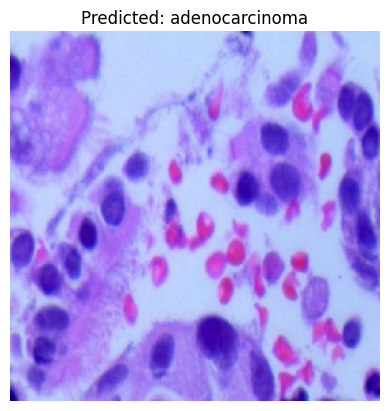

In [39]:
# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()